# Capstone Research
### Tim Holthuijsen
This is the Climate Model Correction Research for my AUC capstone. In this Jupyter Notebook, I will perform multiple types of error analysis on Climate Model Outputs in order to quanity and recognize patterns in climate model error. I will then use a combination of Machine Learning, Deep Learning and statistical techniques to predict and reduce these patterns of Climate Model errors, yielding an Algorithm for Climate Model Improvement. This method can be reproduced with any other climate model outputs, and has proven to significantly improve the accuracy of the Global Ensemble Forecast System model data: reducing its inaccuracy by more than 83%.

#### Imports

In [1]:
import numpy as np
import netCDF4 as nc
import random
import csv
import pandas as pd
import statistics
from sklearn import tree
from dtreeviz.trees import dtreeviz
from sklearn.model_selection import train_test_split

## Loading the Data
We can begin this analysis after loading the reforecast temperature dataset into the reforecast variable

In [2]:
ModelData = 'Reforecast_tmp_2m.nc'
reforecast = nc.Dataset(ModelData)

In [3]:
print(reforecast)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.0
    title: Subset of data from 2nd-generation multi-decadal ensemble reforecast generated from the NCEP Global Ensemble Forecast System, mimicking version operational at NCEP/EMC circa mid-2012.
    institution: NOAA Earth System Research Laboratory (ESRL)
    source: NCEP GFS v 9.01, T254L42.  Control initial conditions from CFSRR.  Perturbed initial conditions from ETR.  Model error simulated with STTP.
    references: http://www.esrl.noaa.gov/psd/forecasts/reforecast2/index.html
    history: Subset created 2020-09-16 19:56:10 UTC
    comment: Original dataset generated on DOE's supercomputers at Lawrence Berkeley Laboratory through ALCC/ASCR grant.
    dimensions(sizes): time(12892), lat(181), lon(360), fhour(5)
    variables(dimensions): float64 time(time), int32 intTime(time), float32 lat(lat), float32 lon(lon), int32 fhour(fhour), int32 intValidTime(time, fhour), 

Setting the lons, lats, and temp variables for the dataset

In [4]:
lons = reforecast.variables['lon'][:]
lats = reforecast.variables['lat'][:]
#We initially remove the time dimension from temp so we can display it in 2D
temp = reforecast.variables['Temperature_height_above_ground'][0,0,:,:]


temp_units = reforecast.variables['Temperature_height_above_ground'].units

Now we can Plot the temperature in the Reforecast dataset along its respective longtitude and latitude, using the Cartopy package on a Plate Carrée map transform.

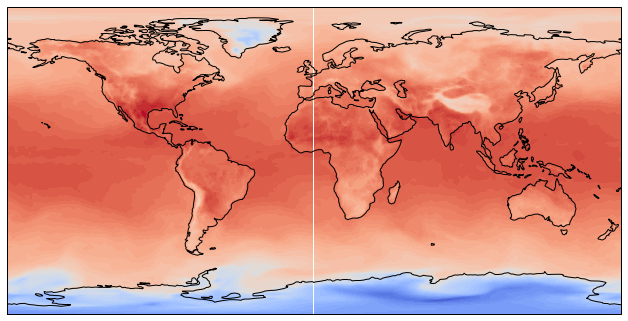

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

plt.figure(figsize=(11,8.8))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, temp, 60, cmap = 'coolwarm',
             transform=ccrs.PlateCarree())

ax.coastlines()

plt.show()

### Reanalysis
We can now repeat this process to get the Reanalysis data mapped out:

In [6]:
pathreanalysis = 'Reanalysis_2mtempNC.nc'
reanalysis = nc.Dataset(pathreanalysis)

In [7]:
print(reanalysis)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2020-09-16 04:55:14 GMT by grib_to_netcdf-2.16.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/data4/adaptor.mars.internal-1600230107.3973272-25431-19-f93c8760-6f1c-406a-8f4c-b12b8c12304f.nc /cache/tmp/f93c8760-6f1c-406a-8f4c-b12b8c12304f-adaptor.mars.internal-1600230107.3978748-25431-6-tmp.grib
    dimensions(sizes): longitude(1440), latitude(721), expver(2), time(488)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 expver(expver), int32 time(time), int16 t2m(time, expver, latitude, longitude)
    groups: 


In [8]:
lonsr = reanalysis.variables['longitude'][:]
latsr = reanalysis.variables['latitude'][:]
#We initially remove the time dimension from temp so we can display it in 2D
tempr = reanalysis.variables['t2m'][0,0,:,:]



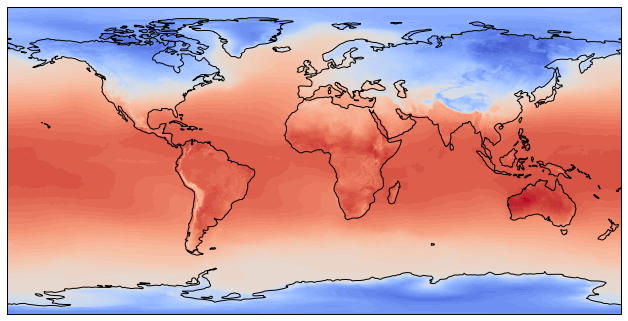

In [9]:
plt.figure(figsize=(11,8.8))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lonsr, latsr, tempr, 60, cmap = 'coolwarm',
             transform=ccrs.PlateCarree())

ax.coastlines()

plt.show()

### Variating over Time
We now make an attempt to variate the temperature map over time, showing global temeprature at the second timeslot in the dataset

In [10]:
timereforecast = reforecast.variables['time'][:]
timereanalysis = reanalysis.variables['time'][:]
reforecasttimeunits = reforecast.variables['time'].units
print(reforecasttimeunits)
reanalysistimeunits = reanalysis.variables['time'].units
print(reanalysistimeunits)

hours since 1800-01-01 00:00:00
hours since 1900-01-01 00:00:00.0


In [11]:
firstreforecast = timereforecast[0]
firstreanalysis = timereanalysis[0]
lastreforecast = timereforecast[len(timereforecast)-1]
lastreanalysis = timereanalysis[len(timereanalysis)-1]
print("The reforecast dataset starts at", firstreforecast, "hours since 1800, and stops at", lastreforecast)
print("The reanalysis dataset starts at", firstreanalysis, "hours since 1900, and stops at", lastreanalysis)

The reforecast dataset starts at 1625304.0 hours since 1800, and stops at 1934688.0
The reanalysis dataset starts at 701256 hours since 1900, and stops at 1057008


Converting this to actual dates leads us to:

In [12]:
import datetime
def converttime(original, hours):
    """
    We define a function that takes a year and the number of hours since that year as input,
    and gives the actual time as a date as output
    """
    old = datetime.datetime(original, 1, 1)
    hours_added = datetime.timedelta(hours= hours)
    real_date = old + hours_added
    return real_date

In [13]:
#We then use this function to convert the start and end dates of the datasets:
reanalysisstart = converttime(1900, 701256)
reanalysisend = converttime(1900, 1057008)
reforecaststart = converttime(1800, 1625304.0)
reforecastend = converttime(1800, 1934688.0)
print("the reforecast starts at", reforecaststart, "and ends at", reforecastend)
print("the reanalysis starts at", reanalysisstart, "and ends at", reanalysisend)

the reforecast starts at 1985-06-01 00:00:00 and ends at 2020-09-16 00:00:00
the reanalysis starts at 1980-01-01 00:00:00 and ends at 2020-08-01 00:00:00


In [14]:
alltimes = reanalysis.variables['time'][:]
timestep = alltimes[1] - alltimes[0]
print("the time elapsed between the first and second timestep is:", timestep, "hours, or 1 month")

the time elapsed between the first and second timestep is: 744 hours, or 1 month


We now display the second timeslot, and check whether the temperature map is indeed different from the one a month earlier. The map does indeed show slight differences in the temperature distribution, showing that we have succesfully taken a step in time across the dataframe

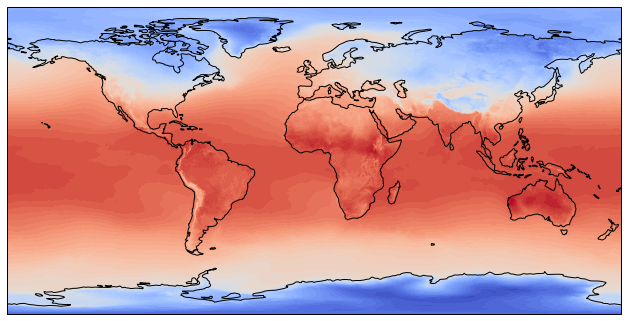

In [15]:
#Second timeslot
tempr2 = reanalysis.variables['t2m'][1,0,:,:]

plt.figure(figsize=(11,8.8))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lonsr, latsr, tempr2, 60, cmap = 'coolwarm',
             transform=ccrs.PlateCarree())

ax.coastlines()

plt.show()

# Data Processing
As becomes apparent from the differences in these two figures, the reforecast and reanalysis datasets show significantly differing temperatue patterns. In order to compare and quantify the differences in these patterns, we will subtract the Reforecast dataset from the Reanalsysi dataset in order to get the model errors. In order to do this, we first have to get both datasets into the same dimensions, regarding both time and spatial resolutions. We will get into converting these dimensions now:


From this initial comparison between the pictures, it already becomes apparent that the datasets seem rather different. However, at the moment, a large part of this difference can also be attributed to the fact that the datasets are not displaying the global temperature at exactly the same time. In order to get these maps to show the same point in time, we have to get the time variable sorted out:

In [16]:
ReanalysisTempTime = reanalysis.variables['t2m'][:,0,:,:]
ReforecastTempTime = reforecast.variables['Temperature_height_above_ground'][:,0,:,:]
timereforecast = reforecast.variables['time'][:]
timereanalysis = reanalysis.variables['time'][:]

In [17]:
timereforecast

masked_array(data=[1625304., 1625328., 1625352., ..., 1934640., 1934664.,
                   1934688.],
             mask=False,
       fill_value=1e+20)

In [18]:
#We use the .units function to figure out what format the time is written in
reforecasttimeunits = reforecast.variables['time'].units
print(reforecasttimeunits)
reanalysistimeunits = reanalysis.variables['time'].units
print(reanalysistimeunits)

hours since 1800-01-01 00:00:00
hours since 1900-01-01 00:00:00.0


So as we can see above, the reforecast's time variable is set in number of hourse since 1800-01-01, while the reanalysis shows number of hours since 1900-01-01. To get these into the same format, some converting will need to be done:

In [19]:
print("reforecast time unit minimum is:",min(timereforecast), "maximum is:",max(timereforecast))
print("reanalyisis time unit minimum is:",min(timereanalysis),"maximum is:",max(timereanalysis))

reforecast time unit minimum is: 1625304.0 maximum is: 1934688.0
reanalyisis time unit minimum is: 701256 maximum is: 1057008


There is exactly a 100-year difference between the two datasets time units. We can use this to our advantage in converting them:

In [20]:
#calculating the number of hours in a year
HoursPerYear = 24 * 365.25
#number of hours per year times 100 years is how the data needs to be adjusted
adjustment = HoursPerYear * 100

In [21]:
#And then we use this adjustment to get the two datasets into the same format
adjustedtimereanalysis = timereanalysis + adjustment

And then the extent should line up more nicely:

In [22]:
print("reforecast time unit minimum is:",min(timereforecast), "maximum is:",max(timereforecast))
print("reanalyisis time unit minimum is:",min(adjustedtimereanalysis),"maximum is:",max(adjustedtimereanalysis))

reforecast time unit minimum is: 1625304.0 maximum is: 1934688.0
reanalyisis time unit minimum is: 1577856.0 maximum is: 1933608.0


As shown above, the datasets overlap for the largest part now, which is exactly as was to be expected. The overlap is not perfect because the reforecast dataset goes from 1-6-1985 until 16-9-1985 while the reanalysis dataset goes from 1-1-1980 until 1-8-2020.
We will therefore only use the overlapping timeslot for our analysis: from 1-6-1985 until 1-8-2020. Or, in Netcdf time units: from 1625304 until 1933608

Right now, the reanalysis dataset starts at an earlier point in time, and the reforecast ends at a later one. To get them both in the same shape, we start cropping the respective time datasets:

In [23]:
#We now use a for loop to determine at which place we have to crop the reforecast
counter = 0
for item in timereforecast:
    counter += 1
    if item == max(adjustedtimereanalysis):
        break
print(counter)

12847


In [24]:
print("meaning we have to remove the last", len(timereforecast) - counter, "time indexes from the reforecast")

meaning we have to remove the last 45 time indexes from the reforecast


In [25]:
#And the same for cropping the start of the reanalysis
counter = 0
for item in adjustedtimereanalysis:
    counter += 1
    if item > min(timereforecast):
        break
print("meaning we have to remove the first", counter, "time indexes from the reanalysis")

meaning we have to remove the first 66 time indexes from the reanalysis


In [26]:
#Cropping
timereforecast = timereforecast[0:12847]
croppedtimereanalysis = adjustedtimereanalysis[66:488]
print(timereforecast.shape)
print(croppedtimereanalysis.shape)

(12847,)
(422,)


Now, both time datasets span exactly the same space in time: from 1-1-1980 until 1-8-2020. However, the reforecast still has a much higher temporal resolution, as seen above. To get them in the same resolution, we reduce the reforecast's resolution to match that of the reanalysis:

In [27]:
#We see which reforecasttimes line up with the reanalysis
usedtimes = []
usedindexes = []
counter = 0
for time in timereforecast:
    if time in croppedtimereanalysis:
        usedindexes.append(counter)
        usedtimes.append(time)
    counter = counter + 1
print("Ideally, we'd use 422 reforecast indexes, and the amount we use is:", len(usedindexes))

Ideally, we'd use 422 reforecast indexes, and the amount we use is: 422


We create a list x, which is True for every time index in reforecast that we want to keep (422), and False for each one we want to throw away

In [28]:
x = []
for i in range(12892):
    if i in usedindexes:
        x.append(True)
    else:
        x.append(False)
    

In [29]:
x = []
for i in range(12847):
    if i in usedindexes:
        x.append(True)
    else:
        x.append(False)
croppedtimereforecast = timereforecast[x]
#temptimereforecast = reforecast.variables['Temperature_height_above_ground'][0:12847,:,:,:]
x = []
for i in range(12892):
    if i in usedindexes:
        x.append(True)
    else:
        x.append(False)
croppedtemptimereforecast = reforecast.variables['Temperature_height_above_ground'][x,:,:,:]

### Data organization
Because we have transformed and converted all datasets a lot, we do a quick reorganization to get all of the data we will be working with in the same nameformat. Additionally, the reanalysis dataset has a 4 times higher spatial resolution than the reforecast data, so we reduce the reanalysis resolution to match the reforecast exactly.

In [30]:
#Setting Time variables for both datasets
ReforecastTime = croppedtimereforecast
ReanalysisTime = croppedtimereanalysis

#Setting Temperature variables
ReforecastTemp = temp
ReanalysisTemp = tempr[::4,::4]

#Setting Temp variables with cropped time
ReforecastTempTime = croppedtemptimereforecast
ReanalysisTempTime = reanalysis.variables['t2m'][66:488,0,::4,::4]
#ReanalysisFullResolution = reanalysis.variables['t2m'][66:488,0,::-1,:]

#longitude
ReforecastLon = lons
ReanalysisLon = lonsr[::4]

#Latitude
ReforecastLat = lats
ReanalysisLat = latsr[::4]

#Creating the final maps with matching resolutions
ReforecastFinal = ReforecastTempTime[:,0,:,:]
ReanalysisFinal = ReanalysisTempTime[:,::-1,:]

if ReforecastFinal.shape == ReanalysisFinal.shape:
    print("It worked! The data is comparable!!")

It worked! The data is comparable!!


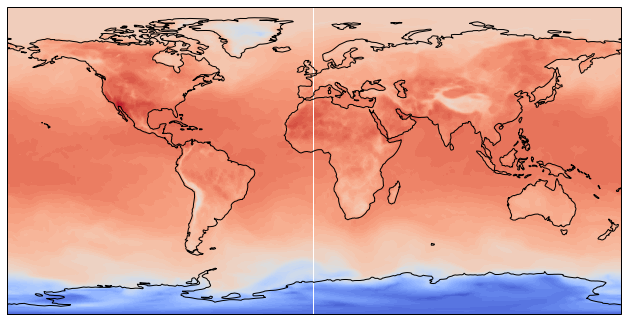

In [31]:
#Plot the reforecast data in its final format
plt.figure(figsize=(11,8.8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(ReforecastLon, ReforecastLat, ReforecastFinal[0,:,:], 60, cmap = 'coolwarm',
             transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

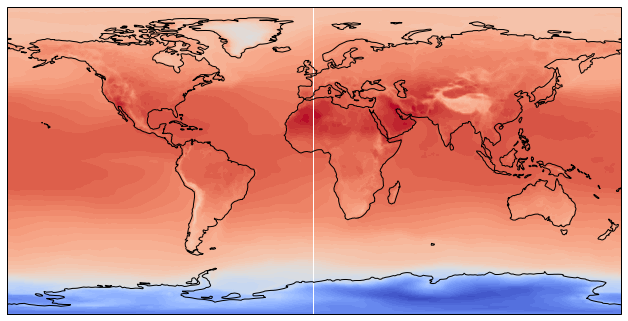

In [32]:
#And the final Reanalysis Data
plt.figure(figsize=(11,8.8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(ReforecastLon, ReforecastLat, ReanalysisFinal[0,:,:], 60, cmap = 'coolwarm',
             transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

# Systematic Comparison
### More than 27 million datapoints!
Since the temporal and spatial resoltuions of the datasets were significantly different, a lot of data was lost while cropping the resolutions to match each other. However, we are still left with 181 x 360 = 65,160 datapoints per map, over 422 different moments in time, resulting in a total of 181 x 360 x 422 = 27,497,520 datapoints over which we can perform our analysis. This is a very large training set, and should be more than enough to train any machine learning model to predict the climate model inaccuracy.

Now that we have transformed the reanalysis and reforecast datasets to match each other exactly, it should be convenient to compare them and quantify their discrepancies

In [33]:
ReanalysisFinal.shape

(422, 181, 360)

In [34]:
ReforecastFinal.shape

(422, 181, 360)

Now that we got the reanalysis and reforecast in the same resolution, we can calculate the model error by subtracting the reforecast from the reanalysis array. The value that this yields is the difference between the reforecasted model predictions by the GEFS and the Reanalysis temperature values by ERA5. This is a crude definition of model error, since the reanalysis itself may contain unaccounted model Bias, which could dismantle the validity of this comparison. Therefore we will compare the error data created by our initial error estimation with a more sophisticated error estimation which is based on observational data later in this development. If the initial and observational errors appear relatively close to one another we will use the initial error estimation for our analysis since it contains a vast amount of datapoints. If the two error estimations diverge significantly however, we will use an error estimation based on purely observational data instead. But first, we define and calculate our total error estimation:

In [35]:
AbsoluteError = ReanalysisFinal - ReforecastFinal

## Climate model error
Then, we can display the climate model error on a global scale as shown below. The red places indicate that the model prediction was too low, and the blue places indicate the model prediction was too high. Very interesting patterns can be discerned from this map, which will be investigated further in the paper.

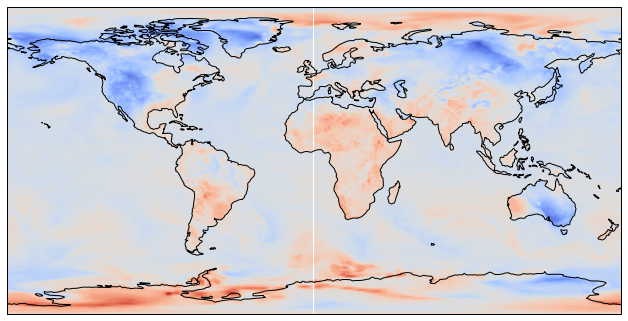

In [36]:
plt.figure(figsize=(11,8.8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lons, lats, AbsoluteError[40,:,:], 60, cmap = 'coolwarm',
             transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

As discussed above, the two maps contain 422 overlapping moments in time. The climate model error for each of these 422 moments differs significantly, and plotting more maps will show widely varying results. To give an indication of this, we show 10 different error maps, equally distributed between 1985 and 2020:

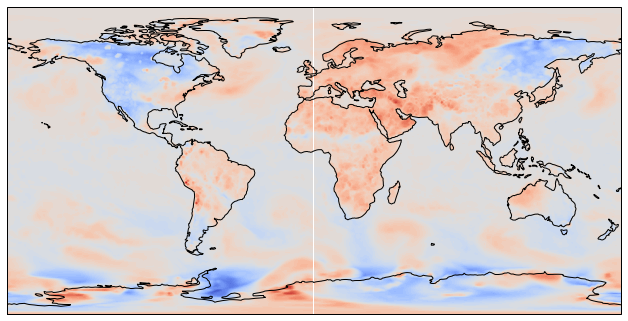

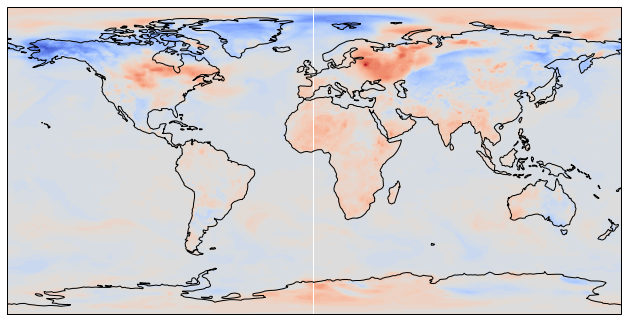

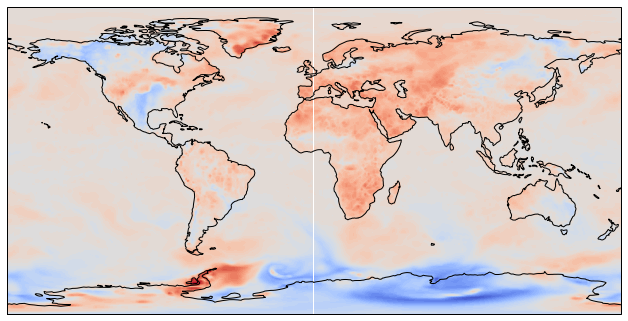

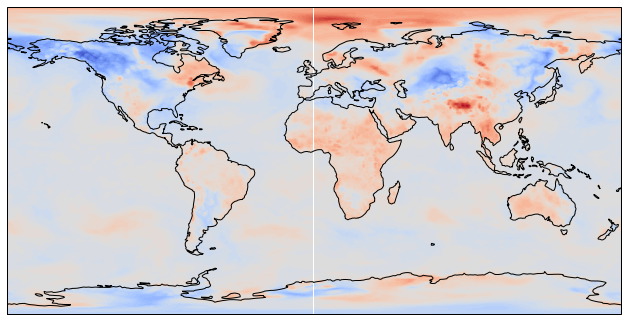

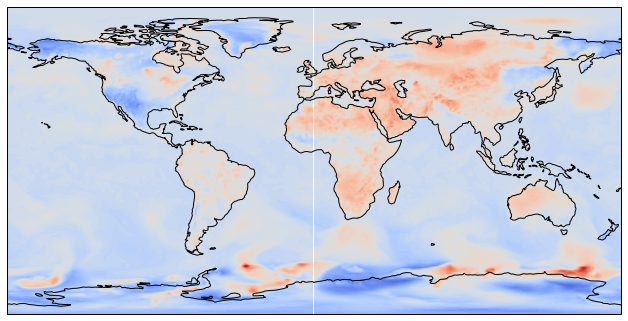

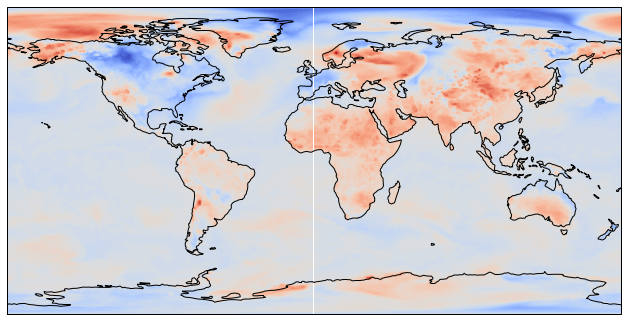

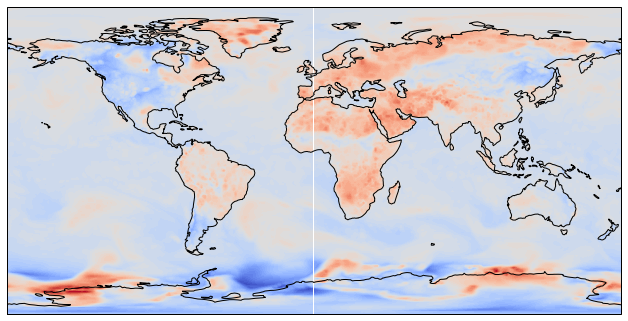

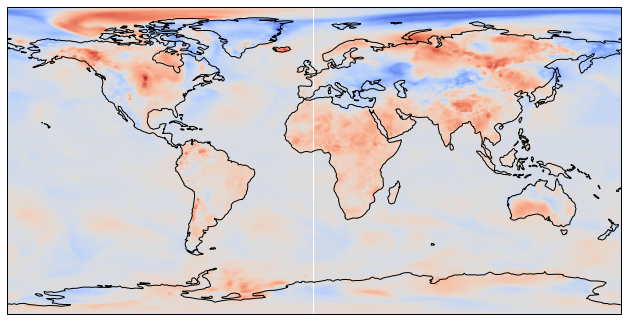

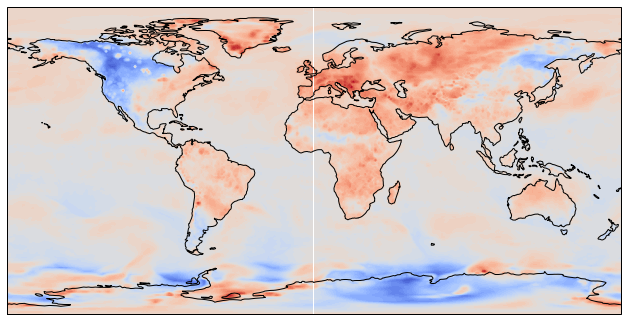

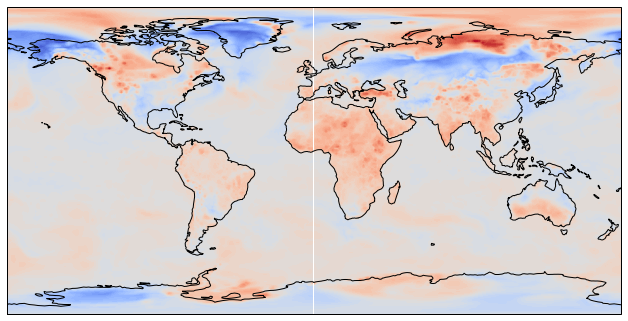

In [37]:
#We show the error for 10 different timeslots
for i in range(10):
    plt.figure(figsize=(11,8.8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    plt.contourf(lons, lats, AbsoluteError[i*42,:,:], 60, cmap = 'coolwarm',
                 transform=ccrs.PlateCarree())
    ax.coastlines()
    plt.show()

# Averaging Error
As can be seen from the maps above, the climate model error varies wildly across different timeslots: not one of the error maps looks the same. While this is good for training our model, it makes it a lot harder to discern model error trends with the naked eye, since you don't know which type of error map is the most common. Therefore, we average all of the model errors from 1985 until 2020, and create one, all-encompassing averaged error map:

In [38]:
#First we calculate the total climate model error in each point
totalerror = AbsoluteError[0,:,:]
for i in range(1,420):
    totalerror = totalerror + AbsoluteError[i,:,:]

#And then divide it to get the average error
AverageError = totalerror/422

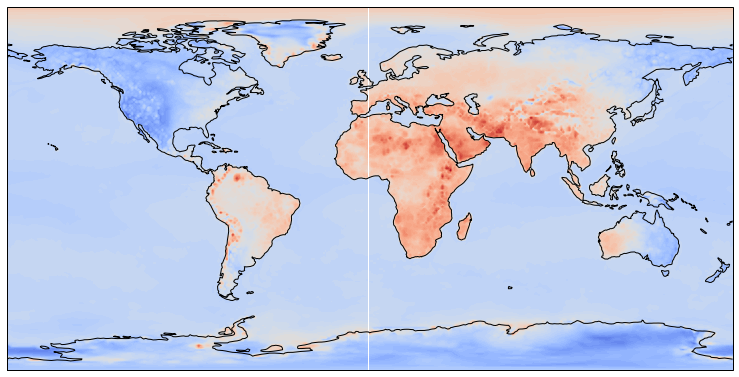

This map holds a large amount of information about climate model inaccuracy


In [39]:
plt.figure(figsize=(13,10.4))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lons, lats, AverageError, 60, cmap = 'coolwarm',
             transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()
print("This map holds a large amount of information about climate model inaccuracy")

# Observational Dataset Validation
In order to check whether our error data doesn't come from the bias in the reanalysis, an observational in-situ temperature dataset is used to validate the accuracy of our error estimation. The observational dataset we use for this is the E-OBS daily gridded meteorological data for Europe from 1950 to present derived from in-situ observations

In [40]:
path = 'EuropeObservations.nc'
Observations = nc.Dataset(path)

obslons = Observations.variables['longitude'][:]
obslats = Observations.variables['latitude'][:]
obstime = Observations.variables['time'][:]
#We only take the temperature in the first time index (0)
obstemp = Observations.variables['tg'][0,:,:]


#temp_units = Observations.variables['Temperature_height_above_ground'].units

In [41]:
Observations

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    CDI: Climate Data Interface version 1.6.3 (http://code.zmaw.de/projects/cdi)
    NCO: netCDF Operators version 4.7.5 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco)
    CDO: Climate Data Operators version 1.6.3 (http://code.zmaw.de/projects/cdo)
    E-OBS_version: 23.1e
    Conventions: CF-1.4
    References: http://surfobs.climate.copernicus.eu/dataaccess/access_eobs.php
    dimensions(sizes): longitude(705), latitude(465), time(25933)
    variables(dimensions): float64 longitude(longitude), float64 latitude(latitude), float64 time(time), float64 tg(time, latitude, longitude)
    groups: 

This is a validation dataset derived from in-situ temperature observations


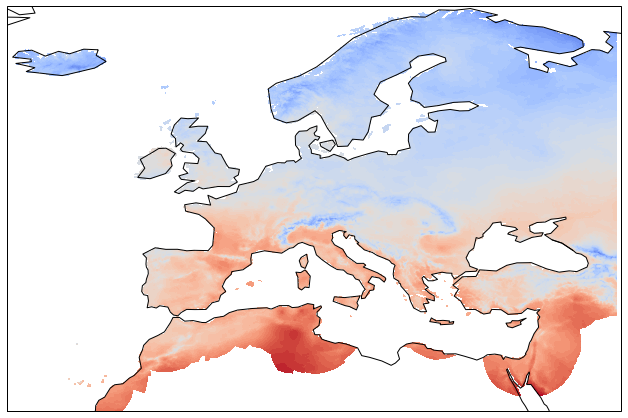

In [42]:
print("This is a validation dataset derived from in-situ temperature observations")
plt.figure(figsize=(11,8.8))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(obslons, obslats, Observations.variables['tg'][12966,:,:], 60, cmap = 'coolwarm',
             transform=ccrs.PlateCarree())

ax.coastlines()

plt.show()

Now, we once again have to make sure that the datasets are shown at the same moment in time, in order to compare them:

In [43]:
ObservationalTimeUnits = Observations.variables['time'].units
print(ObservationalTimeUnits)

days since 1950-01-01 00:00:00


We write some code that gives us all the datetimes used by the error dataset:

In [44]:
datetimes = []
for time in usedtimes:
    datetimes.append(converttime(1800,time))
  

And then we create a function that converts the validation set times to this time:

In [45]:
def observationtime(days):
    """
    We define a function that takes a number of days as input,
    and gives the actual time for the observation set as output
    """
    old = datetime.datetime(1950, 1, 1)
    days_added = datetime.timedelta(days = days)
    real_date = old + days_added
    return real_date

Then, we list all of the in-situ time moments that overlap with the error dataset times:

In [46]:
overlap = []
for i in range(25933):
    if observationtime(i) in datetimes:
        overlap.append(i)
len(overlap)

422

Which allows us to filter the observations times to only the one's we use

In [47]:
#Creating a filter of all used indexes
used = []
for i in range(25933):
    if i in overlap:
        used.append(True)
    else:
        used.append(False)

#filtering times
usedobservationtimes = obstime[used]
#filtering timeslots from temperature
ObservationsFiltered = Observations.variables['tg'][used,:,:]

In [48]:
ObservationsFiltered.shape

(422, 465, 705)

### Spatial resolution
Now that the temporal resolution matches, we do the same with the spatial resolution

In [49]:
convertedlons = []
for lon in obslons:
    integer = int(lon)
    convertedlons.append(integer)
convertedobs = int(obslons[1])

In [50]:
obslats.shape

(465,)

We figure out which indexes we want to use from the observational longitude and latitude

In [51]:
lonindexes = []
for i in range (-25,45):
    difference_array = np.absolute(obslons - i)
    index = difference_array.argmin()
    lonindexes.append(index)
    
latindexes = []
for i in range (25,75):
    difference_array = np.absolute(obslats - i)
    latindex = difference_array.argmin()
    latindexes.append(latindex)


Filtering based on chosen indexes

In [52]:
#longitude
lonfltr = []
for i in range(705):
    if i in lonindexes:
        lonfltr.append(True)
    else:
        lonfltr.append(False)
        
#longitude
latfltr = []
for i in range(465):
    if i in latindexes:
        latfltr.append(True)
    else:
        latfltr.append(False)

#And applying the filters we just made
obslonf = obslons[lonfltr].astype(int)
obslatf = obslats[latfltr].astype(int)
obstemptimelatfltr = ObservationsFiltered[:,latfltr,:]
ObsUncroppedFinal = obstemptimelatfltr[:,:,lonfltr]

In [53]:
ObsUncroppedFinal.shape

(422, 48, 70)

We have now succesfully transformed the validation dataset into a shape comparable with the other datasets!

In [54]:
#converting Celsius to Kelvin
ObsUncroppedFinalCelsius = ObsUncroppedFinal + 273.15

### Cropping model data
Since the validation dataset only shows Europe, whereas the reanalysis and reforecast datasets are on a global scale, we have to clip these datasets to match the extent of the in-situ observations

In [55]:
print("The longitude extent for this dataset is:", min(obslonf),"until",max(obslonf))
print("The latitude extent for this dataset is:", min(obslatf),"until",max(obslatf))

The longitude extent for this dataset is: -24 until 44
The latitude extent for this dataset is: 25 until 71


However, the longitude/latitude units of the model data are different from the one's in the validation set, and do not go into the negatives. Therefore, we will crop the -24 out of the validation set:

### Data organization

In [56]:
#Organizing all of the final observation datasets:
ObsFinalLon = obslonf[25:]
ObsFinalLat = obslatf[0:47]
ObsFinal = ObsUncroppedFinalCelsius[:,0:47,25:]
ObsFinal.shape

(422, 47, 45)

In [57]:
#And we crop the model outputs to the same Europe extent
#Reforecast in Europe
ReforecastLonEu = ReforecastLon[0:45]
ReforecastLatEu = ReforecastLat[115:162]
ReforecastFinalEu = np.array(ReforecastFinal[:,115:162,0:45])
#Reanalysis in Europe
ReanalysisLonEu = ReanalysisLon[0:45]
ReanalysisLatEu = ReanalysisLat[25:72]
ReanalysisFinalEu = np.array(ReanalysisFinal[:,25:72,0:45])
#ReanalysisFinalEUResolution = np.array(ReanalysisFullResolution[:,25:72,0:45])
ReforecastFinalEu.shape

(422, 47, 45)

Plotting the validation and reforecast datasets as they are in their cropped states:

The resolution of the validation set has decreased, but is comparable with the other data now
This is the final validation set we will be using:


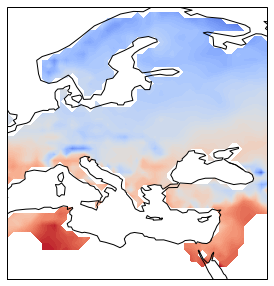

In [58]:
print("The resolution of the validation set has decreased, but is comparable with the other data now")
print("This is the final validation set we will be using:")
plt.figure(figsize=(8,5))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(ObsFinalLon, ObsFinalLat, ObsFinal[0,:,:], 60, cmap = 'coolwarm',
             transform=ccrs.PlateCarree())

ax.coastlines()

plt.show()

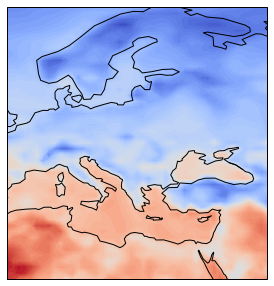

In [59]:
#Plot the cropped reforecast data over the same extent
plt.figure(figsize=(8,5))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(ReforecastLonEu, ReforecastLatEu, ReforecastFinalEu[0,:,:], 60, cmap = 'coolwarm',
             transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

# Comparing Validation and Model Data
Now that everything is in the same shape, we can compare the validation data with both the reforecast and reanalysis datasets, to confirm that the reanalysis is indeed more accurate than the reforecast. We write a function that calculates the Root Mean Square Error (RMSE) of both the Reanalysis and Reforecast datasets, and check their difference. Additionally, this code also calculates the mean value for all 3 datasets

In [60]:
ObservationMean = 0
ReanalysisMean = 0
ReforecastMean = 0
ReanalysisTotalRSE = 0
ReforecastTotalRSE = 0
counter = 0
empties = 0
for t in range(99):
    for lon in range(44):
        for lat in range(42):
            #Check for NaN values in observational set
            if not isinstance(ObsFinal[t,lon,lat], float):
                empties = empties + 1
                continue
            #Calculate all relevant statistics
            else:
                counter = counter + 1
                ObservationMean += ObsFinal[t,lon,lat]
                #Remove some glitchy data
                if ReanalysisFinalEu[t,lon,lat] < 300:
                    ReanalysisMean += ReanalysisFinalEu[t,lon,lat]
                ReforecastMean += ReforecastFinalEu[t,lon,lat]
                ReanalysisAddition = ((ObsFinal[t,lon,lat] - ReanalysisFinalEu[t,lon,lat])**2)**0.5
                ReforecastAddition = ((ObsFinal[t,lon,lat] - ReforecastFinalEu[t,lon,lat])**2)**0.5
                #Remove some NaN errors
                if ReanalysisAddition < 4:
                    ReanalysisTotalRSE = ReanalysisTotalRSE + ReanalysisAddition
                ReforecastTotalRSE = ReforecastTotalRSE + ReforecastAddition
ObsMean = ObservationMean/counter
MeanReanalysis = ReanalysisMean/counter
MeanReforecast = ReforecastMean/counter
ReanalysisRMSE = ReanalysisTotalRSE/counter
ReforecastRMSE = ReforecastTotalRSE/counter
#And print everything calculated
print("Observational Mean temperature is:", ObsMean)
print("Reanalysis Mean temperature is:", MeanReanalysis)
print("Reforecast Mean temperature is:", MeanReforecast)
print("Reanalysis RMSE is:", ReanalysisRMSE)
print("Reforecast RMSE is:", ReforecastRMSE)
print("The number of empty cells in the in-situ set is:", empties)
print("The number of cells used for this calculation is:", counter)

Observational Mean temperature is: 281.8357692964492
Reanalysis Mean temperature is: 282.08645851635646
Reforecast Mean temperature is: 279.22089035193795
Reanalysis RMSE is: 0.3871154555500108
Reforecast RMSE is: 3.2285095695827497
The number of empty cells in the in-situ set is: 77889
The number of cells used for this calculation is: 105063


# Result: The Reanalysis is way more accurate than the Reforecast!
The Reanalysis dataset has an RMSError of only 0.387 on the observational dataset, whereas the Reforecast has an RMSError of 3.23. This proves that the Reanalysis data is indeed a lot more accurate than the reforecast, and that we can keep using it as an authoritative dataset whose accuracy our final model will strive to achieve. If we can get the accuracy of our predictions of the future close to the accuracy of our predictions of the past (reanalysis), this would be an incredible feat and significantly reduce the error measure in contemporary climate models.

### How accurate are the model predictions if we take Reanalysis data as baseline?
Instead of taking the absolutely true observation dataset as baseline, we now want to check what the RMSE of the reforecast would be if we take the Reanalysis dataset as the validation baseline. Therefore, we define a more general RMSE function that we can keep using to test different models, and start it off by testing the initial Reforecast RMSE

In [61]:
ReforecastFinal.shape

(422, 181, 360)

In [62]:
def RMSE(Model,Validation,Time=422,Lon=181,Lat=360,verbose=True,verboseExtra=False):
    """
    A function that takes two array-like climate datasets
    and returns their RMSE
    """
    ValidationArray = np.array(Validation)
    ModelArray = np.array(Model)
    TotalRSE = 0
    counter = 0
    empties = 0
    if Time == 1:
        for lat in range(Lat-7):
            for lon in range(Lon-7):
                counter = counter+1
                RSEAddition = (((ValidationArray[lon,lat] - ModelArray[lon,lat])**2)**0.5)
                TotalRSE = TotalRSE + RSEAddition
    else:
        for t in range(Time-7):
            for lat in range(Lat-7):
                for lon in range(Lon-7):
                    counter = counter+1
                    RSEAddition = (((ValidationArray[t,lon,lat] - ModelArray[t,lon,lat])**2)**0.5)
                    if verboseExtra:
                        if counter%100000 == 0:
                            print(RSEAddition)
                    TotalRSE = TotalRSE + RSEAddition
    RMSE = TotalRSE/counter
    if verbose:
        print("The number of cells used for this calculation is:", counter)
    return RMSE
    

In [63]:
InitialRMSE = RMSE(ReforecastFinal,ReanalysisFinal)
print("The initial RMSE of the Reforecast dataset is:", InitialRMSE)

The number of cells used for this calculation is: 25490130
The initial RMSE of the Reforecast dataset is: 2.829430785702018


The fact that the RMSE of the reforecast on the reanalysis is lower than the RMSE on the observations is an interesting result, which will be discussed further in the accompanying paper.

This is what we will try to improve and reduce by using machine learning on the reforecast dataset

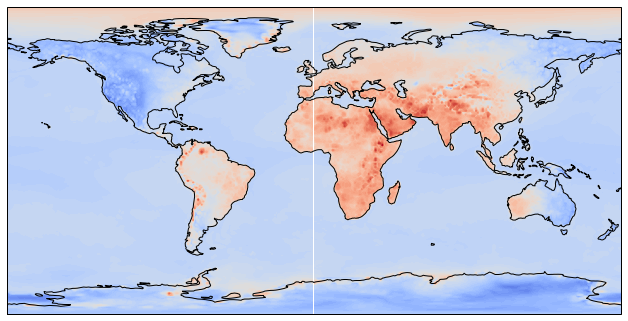

In [64]:
#Average Model Error
plt.figure(figsize=(11,8.8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lons, lats, AverageError, 60, cmap = 'coolwarm',
             transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

# Train/Test Split
In order to train and validate our data, we split it up in a training and a test set, allocating 70% of our data to the training set, and 30% to the test set. We want to keep the individual climate maps together, so we randomly take 70% of our 422 individual moments in time and allocate that as the training set.

In [65]:
random.seed(42)
TrainSize = int(0.7 * 422)
TrainTimes = []
TestTimes = []
for i in range(422):
    TestTimes.append(i)
for i in range(TrainSize):
    item = random.choice(TestTimes)
    TestTimes.remove(item)
    TrainTimes.append(item)    

In [66]:
#First we define all the train and test sets
xtrain = np.array(ReforecastFinal[:,:,:])
xtest = np.array(ReforecastFinal[:,:,:])
ytrain = np.array(ReanalysisFinal[:,:,:])
ytest = np.array(ReanalysisFinal[:,:,:])

#And then we remove the test times from the train set
for i in reversed(sorted(TestTimes)):
    xtrain = np.delete(xtrain,i,axis=0)
    ytrain = np.delete(ytrain,i,axis=0)
#And vice versa  
for i in reversed(sorted(TrainTimes)):
    xtest = np.delete(xtest, i, axis=0)
    ytest = np.delete(ytest, i, axis=0)

#Quick check to see if it worked
if ytrain.shape == xtrain.shape and ytest.shape == xtest.shape:
    print("The Train/Test split worked succesfully!")

The Train/Test split worked succesfully!


Now that we have the data we are going to work with set up, we determine the baseline RMSE that our training set has. The goal is to reduce this RMSE

In [67]:
print("BaselineRMSE is:",RMSE(xtrain,ytrain,Time=20))

The number of cells used for this calculation is: 798486
BaselineRMSE is: 2.900223335029154


# Adding more training data
With just the Reforecast temperature data, it will be hard to train the reforecast to be much better. Therefore, we add some additional data that we can train with. I have created a Global Landuse Classification map using Supervised image classification in ArcGIS. We will now load this Landuse NetCDF map, in addition to more climate data reforecasted by the climate model: cloud cover and precipitation.

In [68]:
pathlanduse = 'LanduseNetCDF.nc'
Landuse = nc.Dataset(pathlanduse)

pathprecipitation = 'PrecipitationReforecast.nc'
precipitation = nc.Dataset(pathprecipitation)

pathcloudcover = 'CloudCoverReforecast.nc'
cloudcover = nc.Dataset(pathcloudcover)

In [69]:
Landuselon = Landuse.variables['lon'][:]
Landuselat = Landuse.variables['lat'][:]
Landusetype = np.array(Landuse.variables['LowResLanduse'][:,:])

In [70]:
cloudcover

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.0
    title: Subset of data from 2nd-generation multi-decadal ensemble reforecast generated from the NCEP Global Ensemble Forecast System, mimicking version operational at NCEP/EMC circa mid-2012.
    institution: NOAA Earth System Research Laboratory (ESRL)
    source: NCEP GFS v 9.01, T254L42.  Control initial conditions from CFSRR.  Perturbed initial conditions from ETR.  Model error simulated with STTP.
    references: http://www.esrl.noaa.gov/psd/forecasts/reforecast2/index.html
    history: Subset created 2019-12-04 08:50:04 UTC
    comment: Original dataset generated on DOE's supercomputers at Lawrence Berkeley Laboratory through ALCC/ASCR grant.
    dimensions(sizes): time(12598), lat(181), lon(360), fhour(1)
    variables(dimensions): float64 time(time), int32 intTime(time), float32 lat(lat), float32 lon(lon), int32 fhour(fhour), int32 intValidTime(time, fhour), 

In [71]:
Precip = precipitation.variables['Total_precipitation'][:,0,:,:]
Cloud = cloudcover.variables['Total_cloud_cover'][:,0,:,:]

We filter the precipitation Dataset time to only the moments we use

In [72]:
x = []
for i in range(12419):
    if i in usedindexes:
        x.append(True)
    else:
        x.append(False)

In [73]:
xprecip = []
for i in range(12419):
    if i in usedindexes:
        xprecip.append(True)
    else:
        xprecip.append(False)
        
#Setting Precipitation variables
PrecipTime = precipitation.variables['time'][xprecip]
PrecipLon = precipitation.variables['lon'][:]
PrecipLat = precipitation.variables['lat'][:]

xcloud = []
for i in range(12598):
    if i in usedindexes:
        xcloud.append(True)
    else:
        xcloud.append(False)
        
#and cloudcover
CloudTime = cloudcover.variables['time'][xcloud]
CloudLon = cloudcover.variables['lon'][:]
CloudLat = cloudcover.variables['lat'][:]
cloudcover.variables['time'].units

'hours since 1800-01-01 00:00:00'

In [74]:
converttime(1800,min(PrecipTime.compressed()))

datetime.datetime(1985, 7, 2, 0, 0)

In [75]:
#and filter the final dataset with the chosen times
PrecipFinal = Precip[xprecip,:,:]
CloudFinal = Cloud[xcloud,:,:]

We create one huge CSV file in which we will input all of our training data:

In [76]:
with open('MegaTable.csv', mode='w') as table:
    writer = csv.writer(table, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    #Write Headers
    writer.writerow(["Lon","Lat","Time","ReforecastTemp","ReanalysisTemp","ModelError",
                     "Precipitation", "CloudCover", "Landuse",
                    "LanduseLon","LanduseLat",
                    "Water","Ice","Land","Shallow Water", "Desert"])
    
    
    for time in range(0,407,30):
        for lon in range(359):
            for lat in range(179):
                #Create all the CSV Variables
                CSVLanduseLongitude = int(Landuselon[lon]) + 180
                CSVLanduseLatitude = -int(Landuselat[lat])
                CSVReforecastLongitude = int(ReforecastLon[lon+1])
                CSVReforecastLatitude = int(ReforecastLat[lat+1])
                CSVReforecastTemp = ReforecastFinal[time,lat+1,lon+1]
                CSVReanalysisTemp = ReanalysisFinal[time,lat+1,lon+1]
                CSVModelError = CSVReanalysisTemp - CSVReforecastTemp
                CSVPrecipitation = PrecipFinal[time,lat+1,lon+1]
                CSVCloudCover = CloudFinal[time,lat+1,lon+1]
                if lon + 180 < 360:
                    CSVLanduseType = Landusetype[-lat,lon+180]
                else:
                    CSVLanduseType = Landusetype[-lat,lon]
                #OneHotEncoder part:
                Water = 0
                Ice = 0
                Land = 0
                ShallowWater = 0
                Desert = 0
                if CSVLanduseType == 1:
                    Water = 1
                if CSVLanduseType == 7:
                    Ice = 1
                if CSVLanduseType == 13:
                    Land = 1
                if CSVLanduseType == 14:
                    ShallowWater = 1
                if CSVLanduseType == 19:
                    Desert = 1
                writer.writerow([CSVReforecastLongitude,CSVReforecastLatitude,time,CSVReforecastTemp,
                                 CSVReanalysisTemp,CSVModelError, CSVPrecipitation, CSVCloudCover, CSVLanduseType,
                                 CSVLanduseLongitude, CSVLanduseLatitude, 
                                 Water, Ice, Land, ShallowWater, Desert])

### Setting up a general error adjustment
Our initial approach will be to calculate the average model error, and then to remove this error from the test set and see whether its accuracy has improved:

In [77]:
#Calculating the average mistakes made by the training set on every place
TotalGeneralError = ytrain - xtrain
GeneralError = TotalGeneralError[0,:,:]
for i in range(1,294):
    GeneralError = GeneralError + TotalGeneralError[i,:,:]
GeneralError = GeneralError/295

In [78]:
GeneralError.shape

(181, 360)

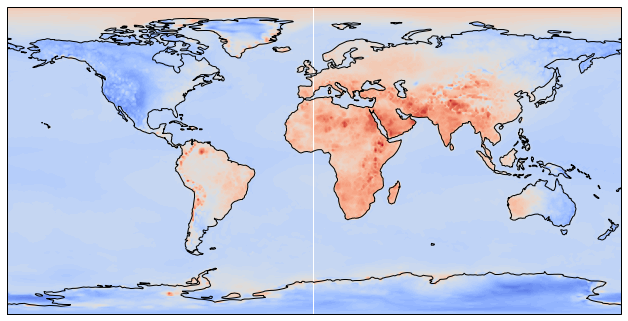

In [79]:
#Average Model Error over only the training set
plt.figure(figsize=(11,8.8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lons, lats, GeneralError, 60, cmap = 'coolwarm',
             transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

In [80]:
def minmax(array):
    "Calculates the minimum and maximum values of a n-dimensional masked array"
    first = True
    for lon in range(181):
        for lat in range(360):
            if first:
                minimum = array[lon,lat]
                maximum = array[lon,lat]
                first = False
                continue
            if array[lon,lat] > maximum:
                maximum = array[lon,lat]
            if array[lon,lat] < minimum:
                minimum = array[lon,lat]
    print("maximum is:", maximum)
    print("minimum is:", minimum)
print('Error:')
minmax(GeneralError)
print('Reanalysis Temp:')
minmax(ReanalysisFinal[400,:,:])

Error:
maximum is: 10.093620457459677
minimum is: -7.395532746876754
Reanalysis Temp:
maximum is: 307.31653484825125
minimum is: 228.83482957751806


In [81]:
AverageErroradjusted = xtest + GeneralError

In [82]:
RMSE(AverageErroradjusted, ytest, Time = 125)

The number of cells used for this calculation is: 7247796


2.513232375124481

This very simple form of error reduction by simply removing the average error of the training set from the test set already improves model performance, reducing RMSE from 2.9 to 2.5. While this is only a small improvement, it already shows the power and significance of our error adjustment. Even though an RMSE reduction of 0.4 seems small, this reduction was measured over more than 7 million datapoints, and is very significant.

We show one timestep of the newly adjusted model output


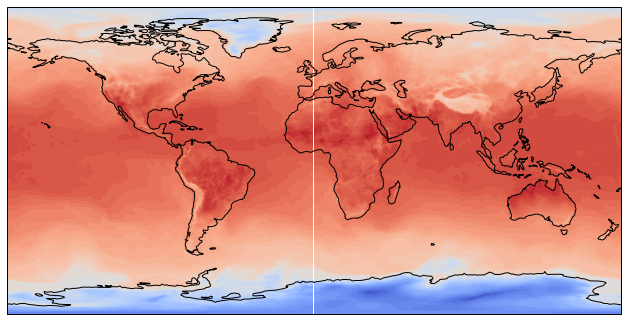

In [83]:
print("We show one timestep of the newly adjusted model output")
plt.figure(figsize=(11,8.8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(ReforecastLon, ReforecastLat, AverageErroradjusted[50,:,:], 60, cmap = 'coolwarm',
             transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

# Training
We now load our MegaTable.csv training set to start training models that can improve climate model predictions even further

In [196]:
MegaTable = pd.read_csv("MegaTable.csv")
#The columns in this variable can be adjusted for feature selection
columns_to_use = [
    "Lon",
    "Lat",
    "Time",
    "ReforecastTemp",
    "Precipitation",
    "CloudCover",
#    "Water","Ice",
#    "Land",
#    "Shallow Water",
#    "Desert"
]


In [197]:
MegaTable[columns_to_use]

,Lon,Lat,Time,ReforecastTemp,Precipitation,CloudCover
0,1,-89,0,216.19092,0.058594,0.031250
1,1,-88,0,216.87842,0.039062,0.023438
2,1,-87,0,219.06592,0.015625,0.023438
3,1,-86,0,218.62842,0.019531,0.019531
4,1,-85,0,217.25342,0.035156,0.023438
...,...,...,...,...,...,...
899649,359,85,390,244.04785,0.570000,90.000000
899650,359,86,390,244.05785,0.300000,83.000000
899651,359,87,390,244.36786,0.060000,70.000000
899652,359,88,390,243.23785,0.050000,53.000000


Create a train/test split for this dataset

In [198]:
#We target to predict the ModelError value
target_column = "ModelError"
x_train, x_test, y_train, y_test = train_test_split(
    MegaTable[columns_to_use], MegaTable[target_column]
)

In [199]:
if len(x_train) == len(y_train):
    print("Train/Test split worked!")

Train/Test split worked!


We first use a linear regression model:

In [200]:
from sklearn.linear_model import LinearRegression
#Initializing the model
Linearmodel = LinearRegression()
#Training the model
Linearmodel.fit(x_train,y_train)

LinearRegression()

In [201]:
print("The intercept of this regression is:", Linearmodel.intercept_)
coefficients = []
counter = 0
for item in Linearmodel.coef_.tolist():
    coefficients.append(columns_to_use[counter])
    coefficients.append(item)
    counter = counter + 1
print("And its coefficients are:", coefficients)

The intercept of this regression is: 1.9120461010523384
And its coefficients are: ['Lon', -0.004100341679224491, 'Lat', 0.008084818626675046, 'Time', -0.00016578579991612512, 'ReforecastTemp', -0.0037973400188777476, 'Precipitation', -0.09970973370925218, 'CloudCover', 0.00020383436302862025]


From this, it becomes apparent that Landuse type seems very important in predicting climate model inaccuracy

In [202]:
y_testLinear = Linearmodel.predict(x_test)

In [203]:
Adjusted = y_test - y_testLinear

In [204]:
def error(prediction, true = y_test):
    """Since we are now predicting error directly rather than temperature,
    we define another function capable of calculating RMSE"""
    PredictionSubstracted = y_test - prediction
    Totalerror = 0
    for modelerror in PredictionSubstracted:
        addition = (modelerror**2)**0.5
        Totalerror = Totalerror + addition
    RMSE = Totalerror/len(prediction)
    return RMSE

In [205]:
#And see how well our linear model performed
error(y_testLinear)

2.5010418608103153

### Success
The Linear regression model is once again a significant improvement over the original Climate model accuracy, reducing RMSE from 2.9 to below 2.5. However, we want to see if we can do even better than this:

In [206]:
#To train more models, we define a function that does it automatically
def ModelMaker(model, x_train = x_train, y_train = y_train,
               x_test = x_test, y_test = y_test, fit = True):
    if fit:
        model.fit(x_train,y_train)
    y_predicted = model.predict(x_test)
    RMSE = error(y_predicted)
    print(model, "yields an RMSE of:", RMSE)
    return RMSE

#And check if it worked
ModelMaker(LinearRegression())

LinearRegression() yields an RMSE of: 2.5010418608103153


2.5010418608103153

In [207]:
#We try some more models with our automatic modeler:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn import linear_model
ModelMaker(Lasso())
ModelMaker(Ridge())
ModelMaker(ElasticNet())


print("The RMSE reduction of these models is comparable with the Linear Regression")


Lasso() yields an RMSE of: 2.5103411177542854
Ridge() yields an RMSE of: 2.5010418627200517
ElasticNet() yields an RMSE of: 2.508459645046081
The RMSE reduction of these models is comparable with the Linear Regression


The statistical models above yield promising results and definitely increase climate model accuracy, but they may not contain sufficiently complex algorithms to completly understand the patterns of climate model inaccuracy. To train more sophisticated models, we will start training Neural Networks to predict climate model inaccuracy, and see how well they perform. We initially start with the Sklearn MLPRegressor:

In [208]:
from sklearn.neural_network import MLPRegressor
#Define the MLP model
ModelMaker(MLPRegressor(max_iter = 500))

MLPRegressor(max_iter=500) yields an RMSE of: 2.191310696153811


2.191310696153811

this Multi-layer Perceptron regressor reaches an RMSE score of 2.03, which is better than any model we have seen before, and significantly better than the Reforecast's original RMSE of 2.90. I believe a more advanced neural network could potentially do better than this, so I will attempt to train a custom neural network later on. But for now, I think we can still do a lot better with a more complex machine learning approach, such as the RandomForestRegressor:
However, I still believe we can do better than this, so we try another complex machine learning approach in the usage of a RandomForestRegressor: 

In [209]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
ModelMaker(linear_model.BayesianRidge())
#The RandomForest with max_depth=2 is not complex enough
#We still try it out, because it is the only way it doesn't take 2 hours to run
ModelMaker(RandomForestRegressor(max_depth=2))

BayesianRidge() yields an RMSE of: 2.501059560888014
RandomForestRegressor(max_depth=2) yields an RMSE of: 2.4655800861787123


2.4655800861787123

The Random Forest Regression seems promising, and has reduced the RMSE more than other statistical model so far. However, to prevent training times of literally 2 hours, I have had to keep the model relatively simple (max_depth=2).
To see if we can improve this by making it more complex, we do some hyperparameter tuning:

In [210]:
ModelMaker(RandomForestRegressor())

RandomForestRegressor() yields an RMSE of: 0.4663212779402351


0.4663212779402351

**Wow!**
That is a really good RMSE score

In [211]:
RandomForestModel = RandomForestRegressor(n_estimators = 250, n_jobs = -1).fit(x_train, y_train)

In [212]:
ModelMaker(RandomForestModel, fit = False)

RandomForestRegressor(n_estimators=250, n_jobs=-1) yields an RMSE of: 0.46272749720955886


0.46272749720955886

Calculating Random Forest R^2 score

In [230]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, RandomForestModel.predict(x_test))
print("RF R squared is:", r2)

RF R squared is: 0.9495162572515055


# Random Forest is incredibly skillfull!
With the Random Forest adjustment, the climate model data only has an RMSE of 0.46, which is an 84% improvement over its original RMSE of 2.90, and thus makes the climate model significantly better at predicting global temperatures

In [213]:
PredictedInaccuracy = RandomForestModel.predict(x_test)

In [214]:
y_testarray = np.array(y_test)

In [215]:
#Some examples of our inaccuracy prediction 
for i in range(0,224914,30000):
    print("Model predicted inaccuracy:",PredictedInaccuracy[i],
          "Actual inaccuray:",y_testarray[i])

Model predicted inaccuracy: 0.713459307565267 Actual inaccuray: 1.6047529287785096
Model predicted inaccuracy: -0.4029680670214998 Actual inaccuray: -1.1804167552332956
Model predicted inaccuracy: -1.0742986604261584 Actual inaccuray: -0.9506179651004912
Model predicted inaccuracy: 2.2780526802589742 Actual inaccuray: 3.7337340954675255
Model predicted inaccuracy: 6.015404232609881 Actual inaccuray: 5.911735837245259
Model predicted inaccuracy: -0.5440276401113241 Actual inaccuray: -0.03304218043501805
Model predicted inaccuracy: 4.2164647917267475 Actual inaccuray: 4.644496809278792
Model predicted inaccuracy: -0.794433234039963 Actual inaccuray: 2.696663383765781


The inaccuracy predicted by our model and the actual inaccuracy show a very strong correlation, as shown above

In [216]:
importances = RandomForestModel.feature_importances_

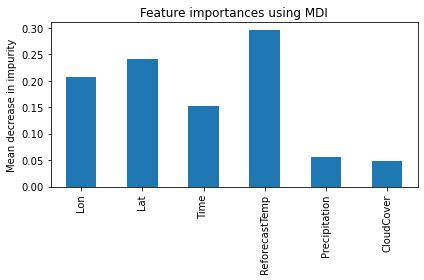

In [217]:
#We plot the importance of each feature for the RF model
std = np.std([
    RandomForestModel.feature_importances_ for tree in RandomForestModel.estimators_], axis=0)
forest_importances = pd.Series(importances, index=columns_to_use)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

It appears that the temperature, location and time are rather important in predicting model inaccuracy, and that landuse type has less influence than expected.

Now that we have our RandomForest model with a ridiculously high accuracy, we attempt to visualize its decision tree to get a better idea of how it works. It is impossible to visualize the entire 250 estimators of the RandomForestModel in one graph, so instead we visualize a more simple model with max_depth=3 to give an indication of how the correction model's decision tree functions

In [218]:
print("The random forest model has:", len(RandomForestModel.estimators_), "estimators")

The random forest model has: 250 estimators


In [219]:
#We train a smaller RF model to realistically render its decision tree
SimpleRandomForest = RandomForestRegressor(max_depth=3).fit(x_train,y_train)

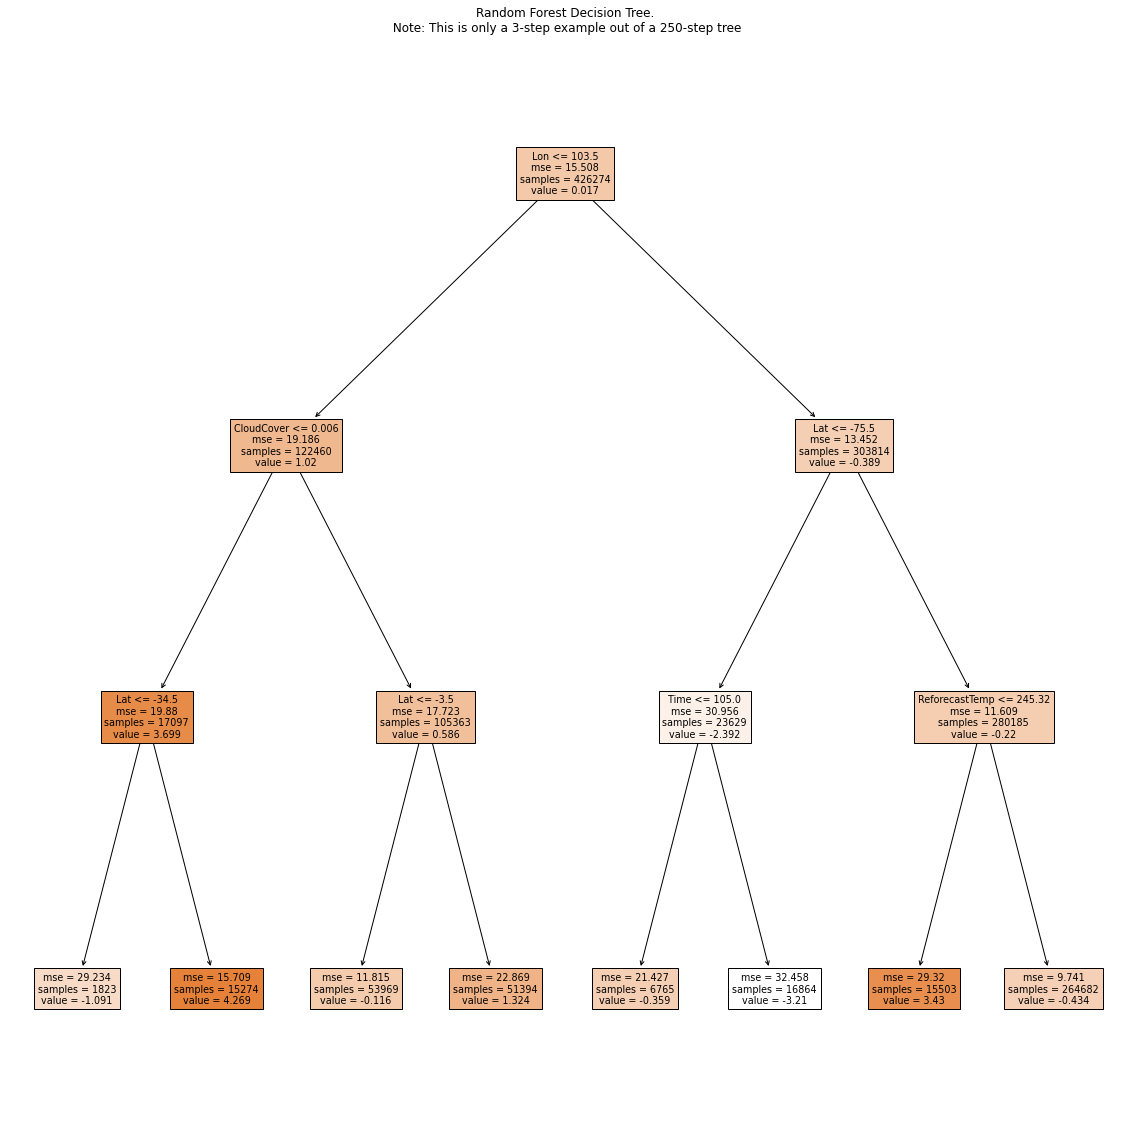

In [220]:
from sklearn import tree
from dtreeviz.trees import dtreeviz

#and we print the decision tree of our depth=3 random forest
plt.figure(figsize=(20,20))
_ = tree.plot_tree(SimpleRandomForest.estimators_[0], feature_names=columns_to_use, filled=True)
plt.title('Random Forest Decision Tree.\n Note: This is only a 3-step example out of a 250-step tree')
plt.savefig('DecisionTree.png')

## Best Model!
It seems that the RandomForestRegressor is the best model we can obtain. The output algorithm of this model is stored in RandomForestModel, and can be remade to tailor corrections specifically for any climate model by changing the ModelData variable all the way at the start of this file. The data inserted into ModelData needs to be a Climate Data NetCDF file with shape [422,360,180] across the dimensions (time,longitude,latitude)

For this specific Climate Model Dataset from the Global Ensemble Forecast System, our correction model has improved its accuracy from 2.90 RMSE to 0.47 RMSE, an accuracy improvement of **more than 83%!**

# Custom Neural Network
To attempt an even more complex solution than the RF network, we attempt to build a custom neural network and teach it to recognize and predict climate model error:

In [221]:
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras import backend as K

#Give it a rmse function the model understands
def root_mean_squared_error(y_true, y_pred):
        return K.mean(K.sqrt(K.square(y_pred - y_true))) 
#This code is commented out because it takes ages to run
#The Neural networks below give a sufficient indication of how the neural networks perform

# define base model
def NeuralNetwork():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, input_dim=6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, input_dim=6, kernel_initializer='normal', activation='relu'))
    #model.add(Dense(2, input_dim=11, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss=root_mean_squared_error, optimizer='adam')
    model.evaluate(x_test, y_test, batch_size = 1000000, verbose = 1)
    return model
# evaluate model
#Set verbose = 1 if you want to see the training process and all the outputs + final accuracy
estimator = KerasRegressor(build_fn=NeuralNetwork, epochs=200, batch_size=1000000, verbose=0)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, x_train, y_train, cv=kfold)


224914/224914 [==============================] - 0s 2us/step
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
224914/224914 [==============================] - 0s 2us/step


Initially, the model starts off with a rather high Loss (rmse) function, of around 2.53. However, after training the model, this rmse quickly goes down, already dropping to 2.41 after 200 epochs. Therefore, we attempt training the model over more epochs.

We try building the same model with 20.000 training epochs, which leads to an rsme of 2.33, as seen below:

In [222]:
#Give it a rmse function the model understands
def root_mean_squared_error(y_true, y_pred):
    #print("y_true is:", y_true)
    #print("y_pred is:", y_pred)
    rmse = K.mean(K.sqrt(K.square(y_pred - y_true)))
    return rmse
def absolute_error(y_true, y_pred):
    error = y_true - y_pred
    return error
    
# define base model
def NeuralNetwork():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, input_dim=6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, input_dim=6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer = 'normal', activation="linear"))
    #model.add(Dense(2, input_dim=11, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss=root_mean_squared_error, optimizer='adam')
    return model
# evaluate model
estimator = KerasRegressor(build_fn=NeuralNetwork, epochs=500, batch_size=1000000, verbose=0)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, x_train, y_train, cv=kfold)
#print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))
#print("The RMSE of this model is:")
#model.evaluate(x_test, y_test, batch_size = 1000000, verbose = 1)

After a while, our RMSE function begins returning NaN as a loss, so instead we use Keras' mean_absolute_error function, as this one stays consistent across the entire training period, and can thus be trained for a larger amount of epochs:

Tuning all of the parameters and architecture some more:

In [223]:


learning_rate = 0.01

model = Sequential()
model.add(Dense(13, input_dim=6, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, kernel_initializer='normal',activation='relu'))
model.add(Dense(10, kernel_initializer='normal',activation='relu'))
model.add(Dense(1, kernel_initializer='normal',activation='linear'))
model.add(Dense(1,kernel_initializer='normal'))
model.compile(loss='mean_absolute_error', optimizer='Adam')

model.fit(x_train,y_train,epochs=10000,batch_size=10000000, verbose=0)

print("The Mean Absolute Error of this model is:")
model.evaluate(x_test, y_test, batch_size = 1000000, verbose = 1)



The Mean Absolute Error of this model is:
224914/224914 [==============================] - 1s 3us/step


2.3328709602355957

after 10.000 epochs of training, the neural network reaches an MAE of 2.25, which is better than the statistical approaches, but worse than the other deep learning methods. The initial SKlearn Mutli-Layer Perceptron (MLP) seems to be a more effective neural network, with a RMSE of 2.19.

We visualize the architecture of the Neural Network:

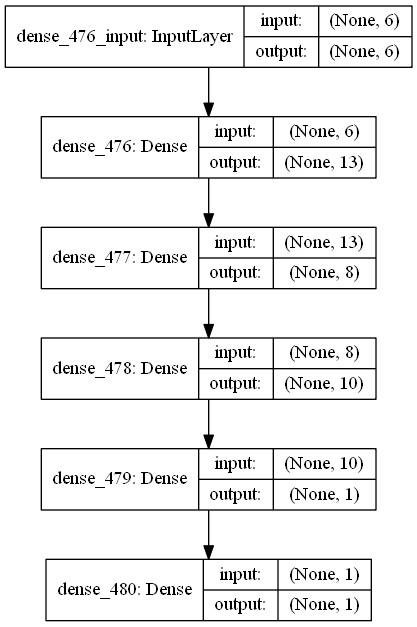

In [224]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [225]:
#And display the weights of the individual neurons
weights = model.get_weights()
weights

[array([[ 2.34248638e-01,  1.89383730e-01, -5.87023906e-02,
          2.59562105e-01,  1.48293197e-01,  7.38569582e-03,
          1.87858604e-02, -2.67098516e-01, -1.88914072e-02,
         -9.29758772e-02, -3.97363544e-01, -2.01413073e-02,
         -9.22746807e-02],
        [ 3.23651545e-02, -9.85702723e-02,  2.54259855e-01,
         -2.25169525e-01,  9.23685059e-02,  8.98852050e-02,
         -4.03006911e-01, -4.85403575e-02, -3.51248533e-01,
          4.05077748e-02, -3.82809453e-02,  1.63221755e-03,
         -2.46588010e-02],
        [ 1.69143118e-02,  4.86979671e-02,  1.15112826e-01,
          3.35909484e-04,  1.33269385e-01,  4.39933827e-03,
          4.46490361e-04,  7.10377377e-03,  1.20565400e-01,
         -3.05164140e-02,  1.05787460e-02,  1.16732372e-02,
          1.49785027e-01],
        [ 1.04505405e-01,  2.03455463e-02,  2.80072510e-01,
         -2.16159932e-02,  1.09112868e-02, -7.55928829e-02,
          3.76502573e-02,  1.28384233e-01,  3.68820906e-01,
         -2.0219797

And that's it. We have now trained multiple machine learning models that can predict and reduce climate model inaccuracy, with varying levels of success. Specifically the large Random Forest Regressor model seems to be very effective at predicting climate model error, and reduces this error from an RMSE of 2.9 to an RMSE of 0.44

In [226]:
#Some leftover code that takes days to run
if False:
    #SVM Attempt
    from sklearn.svm import LinearSVC
    from sklearn import svm
    ModelMaker(svm.SVR())

    #We attempt to render the huge, 250-step decison tree as well
    from sklearn import tree
    from dtreeviz.trees import dtreeviz
    plt.figure(figsize=(400,400))
    _ = tree.plot_tree(RandomForestModel.estimators_[0], feature_names=columns_to_use, filled=True)
    plt.title('Random Forest Decision Tree')
    plt.savefig('DecisionTreeBigBig.png')